# DRIVE MOUNT

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Installing pytesseract to extract text from images usingOptical Character Recognition

In [2]:
!sudo apt install tesseract-ocr
!pip install pytesseract

## Importing necessary libraries

In [3]:
import os
import cv2
import numpy as np
from PIL import Image
import tensorflow as tf
import pytesseract as pt
import plotly.express as px
import matplotlib.pyplot as plt

from google.colab.patches import cv2_imshow
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

### Loading the trained model

In [4]:
# Load model
model = tf.keras.models.load_model('/content/drive/MyDrive/DIP/PlateTracker/PlateTracker/Plate_Tracker.keras')
print('Model loaded Sucessfully')

Model loaded Sucessfully


### creating a pipeline to detect the plate by defining a bounding box of xml coordinates

In [5]:
# Create pipeline
path = '/content/drive/MyDrive/DIP/PlateTracker/PlateTracker/TEST/Red_car.jpeg'
def object_detection(path):

    # Read image
    image = load_img(path) # PIL object
    image = np.array(image,dtype=np.uint8) # 8 bit array (0,255)
    image1 = load_img(path,target_size=(224,224))

    # Data preprocessing
    image_arr_224 = img_to_array(image1)/255.0 # Convert to array & normalized
    h,w,d = image.shape
    test_arr = image_arr_224.reshape(1,224,224,3)

    # Make predictions
    coords = model.predict(test_arr)

    # Denormalize the values
    denorm = np.array([w,w,h,h])
    coords = coords * denorm
    coords = coords.astype(np.int32)

    # Draw bounding on top the image
    xmin, xmax,ymin,ymax = coords[0]
    pt1 =(xmin,ymin)
    pt2 =(xmax,ymax)
    print(pt1, pt2)
    cv2.rectangle(image,pt1,pt2,(0,255,0),3)
    return image, coords

image, cods = object_detection(path)

fig = px.imshow(image)
fig.update_layout(width=700, height=500, margin=dict(l=10, r=10, b=10, t=10),xaxis_title='Figure 14')

1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step
(100, 73) (162, 87)


### Displaying the Region of Interest (ROI) of the plate by cropping it to specific dimensions

In [6]:
img = np.array(load_img(path))
xmin ,xmax,ymin,ymax = cods[0]
roi = img[ymin:ymax,xmin:xmax]# Crop the region of interest (ROI) from the image using the bounding box coordinates
fig = px.imshow(roi)# Display the cropped region (ROI) interactively using Plotly
fig.update_layout(width=350, height=250, margin=dict(l=10, r=10, b=10, t=10),xaxis_title='Plate')

# Extracting text from Image

### Below function is used to extract the text from the ROI without any preprocessing applied

In [10]:
def extract_text_from_roi(roi):
    try:
        # Convert NumPy array to PIL Image if needed
        if isinstance(roi, np.ndarray):
            roi = img[ymin:ymax,xmin:xmax]

        # Extract text with additional configuration for better accuracy
        text = pt.image_to_string(
            roi,
            config='--psm 6 --oem 3',  # Page Segmentation Mode and OCR Engine Mode
            lang='eng'  # Specify language if needed
        )
        return text.strip()
    except Exception as e:
        print(f"Error in text extraction: {e}")
        return ""

# Use the function
text = extract_text_from_roi(roi)
print("Extracted Text:", text)


Extracted Text: LRSS TEER


### Disoplaying the ROI and extratced text

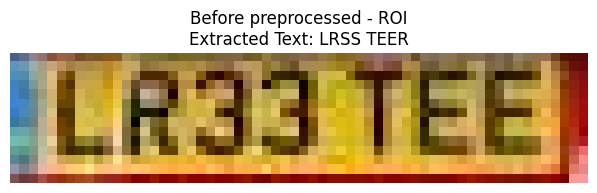

Extracted Text: LRSS TEER


In [19]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 2)
plt.imshow(roi)
plt.title(f'Before preprocessed - ROI\nExtracted Text: {text}')
plt.axis('off')

plt.tight_layout()
plt.show()

text = extract_text_from_roi(roi)
print("Extracted Text:", text)

# Creating a pipeline to extract text from image by applying Digital Image Processing techniques. Displaying the preprocessed ROI and extracted text.

Loading image...
Detecting license plate...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Preprocessing license plate...
Extracting text...
Displaying results...


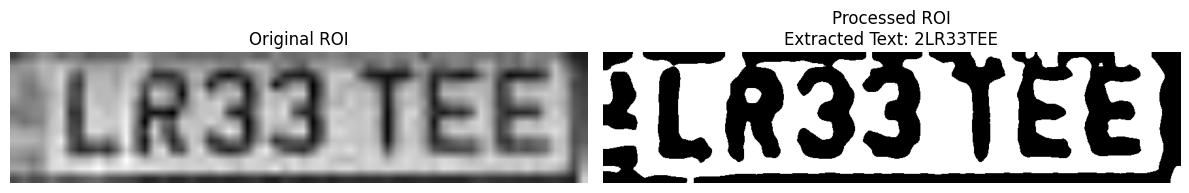


Detected License Plate Number: 2LR33TEE


In [8]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import pytesseract
import warnings
warnings.filterwarnings('ignore')

def preprocess_plate(roi):
    """
    Preprocess the detected license plate ROI
    """
    try:
        # Convert to grayscale if RGB
        if len(roi.shape) == 3:
            gray = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)
        else:
            gray = roi.copy()

        # Resize to larger dimension for better OCR
        height = 200
        aspect_ratio = gray.shape[1] / gray.shape[0]
        width = int(height * aspect_ratio)
        resized = cv2.resize(gray, (width, height))

        # Apply CLAHE for contrast enhancement
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
        contrast_enhanced = clahe.apply(resized)

        # Noise reduction
        denoised = cv2.bilateralFilter(contrast_enhanced, 11, 17, 17)

        # Thresholding
        _, binary = cv2.threshold(denoised, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # Remove small noise
        kernel = np.ones((3,3), np.uint8)
        morph = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

        return morph, resized

    except Exception as e:
        print(f"Error in plate preprocessing: {str(e)}")
        return None, None

def extract_text(processed_roi):
    """
    Extract text from the preprocessed ROI
    """
    try:
        # Configure pytesseract
        custom_config = r'--oem 3 --psm 6 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'

        # Extract text
        text = pytesseract.image_to_string(processed_roi, config=custom_config)

        # Clean text
        text = ''.join(c for c in text if c.isalnum())

        return text

    except Exception as e:
        print(f"Error in text extraction: {str(e)}")
        return ""

def display_results(original_roi, processed_roi, extracted_text):
    """
    Display original ROI, processed ROI, and extracted text
    """
    plt.figure(figsize=(12, 4))

    # Original ROI
    plt.subplot(1, 2, 1)
    if len(original_roi.shape) == 3:
        plt.imshow(original_roi)
    else:
        plt.imshow(original_roi, cmap='gray')
    plt.title('Original ROI')
    plt.axis('off')

    # Processed ROI
    plt.subplot(1, 2, 2)
    plt.imshow(processed_roi, cmap='gray')
    plt.title(f'Processed ROI\nExtracted Text: {extracted_text}')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

def process_license_plate(path):
    """
    Main pipeline for license plate preprocessing and text extraction
    """
    try:
        # Load and prepare image
        print("Loading image...")
        image = load_img(path)
        image = np.array(image, dtype=np.uint8)

        # Prepare for model
        image_for_model = Image.fromarray(image)
        image_for_model = image_for_model.resize((224, 224))
        image_arr = img_to_array(image_for_model)/255.0
        h, w = image.shape[:2]
        test_arr = image_arr.reshape(1, 224, 224, 3)

        # Get predictions
        print("Detecting license plate...")
        coords = model.predict(test_arr)

        # Denormalize coordinates
        denorm = np.array([w, w, h, h])
        coords = coords * denorm
        coords = coords.astype(np.int32)

        # Extract ROI
        xmin, xmax, ymin, ymax = coords[0]
        roi = image[ymin:ymax, xmin:xmax]

        # Preprocess ROI
        print("Preprocessing license plate...")
        processed_roi, resized_original = preprocess_plate(roi)

        if processed_roi is not None:
            # Extract text
            print("Extracting text...")
            plate_text = extract_text(processed_roi)

            # Display results
            print("Displaying results...")
            display_results(resized_original, processed_roi, plate_text)

            return plate_text
        else:
            print("Preprocessing failed!")
            return None

    except Exception as e:
        print(f"Error in pipeline: {str(e)}")
        return None

# Main execution
if __name__ == "__main__":
    try:
        # Replace with your image path
        path = '/content/drive/MyDrive/DIP/PlateTracker/PlateTracker/TEST/Red_car.jpeg'

        # Process the license plate
        plate_text = process_license_plate(path)

        if plate_text:
            print(f"\nDetected License Plate Number: {plate_text}")
        else:
            print("\nFailed to extract license plate text. Please check the error messages above.")

    except Exception as e:
        print(f"Error running pipeline: {str(e)}")